# Climatologie et anomalie 

Job description:

Based on daily, global  sea level height (SLA) analyses we generated some analysis of the data based on the approach :
1. The daily analyses were averaged to create monthly means.
2. A climatology was calculated by averaging the monthly means over the period xxxx - xxxx.
3. Sea level anomalies (SLA )were calculated by differencing the monthly means and the climatology,where anomalies is  the deviation of climatology.
4. Create the files to be used as train and test in the RN such as:

        4.1 Train files orig : XE from 2015 to 2020 in a 300x300 dimension.
        4.2 Test  files orig : XE from 2021 in a 300x300 dimension.
        4.3 Train files segm : SLA from 2015 to 2020 in a 300x300 dimension. (created in PROJET_EDDY_P2.ipynb)
        4.4 Test  files segm : SLA from 2021 in a 300x300 dimension.(created in PROJET_EDDY_P2.ipynb) 

ref:
1. http://gallery.pangeo.io/repos/pangeo-gallery/physical-oceanography/01_sea-surface-height.html

### Import library

In [ ]:
import intake
import dask_hpcconfig
from distributed import Client
import xarray as xr
import hvplot.xarray
import geoviews.feature as gf
import os
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np

# cartopy
from cartopy import config
import cartopy.crs as ccrs

# eddy tracker
from datetime import datetime
from matplotlib import pyplot as plt
from py_eddy_tracker import data
from py_eddy_tracker.dataset.grid import RegularGridDataset

Detail of the imports:
-----------------------------------------------------------------------------------------------  
- Intake

    _Handle the catalog contained in the yaml files._

- dask_hpcconfig

    _Parrallelize your tasks on an hpc like datatrmor._

- distributed import Client

    _Client is creating the dask client_

- Xarray

    _Xarray makes operation on datasets and creates labbeled multidimensional arrays_

- hvplot.xarray

    _Plotting_ 

- geoviews.features

    _Plotting that enables some features on maps_

- os

    _Can handle operating system dependant functionnality_ 

In [2]:
overrides = {"cluster.cores": 7,"cluster.n_workers":7,"cluster.processes":7}
cluster = dask_hpcconfig.cluster("datarmor", **overrides)
cluster.scale(jobs=4)
client = Client(cluster)
client

/home1/datawork/ddasilva/conda-env/pyEddyTracker/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53836 instead
  warnings.warn(


<Client: 'tcp://10.148.0.67:49378' processes=0 threads=0, memory=0 B>

In [10]:
client

<Client: 'tcp://10.148.10.42:43549' processes=28 threads=28, memory=447.16 GiB>

In [15]:
def list_param(cat, param):
    return cat.metadata["parameters"][param]["allowed"]

def allowed_param(cat):
    return cat.metadata["parameters"]

def allowed_years(data):
    path = "/home/datawork-lops-iaocea/catalog/kerchunk/ref-marc/" + data
    files = [f.removesuffix(".json.zst") for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    files.sort()
    
    return files

def year_concat(cat, source, region, years,chunks):
    concat = [cat[source](region=region, year=i,chunks=chunks).to_dask() 
              for i in years]

    return xr.concat(
        concat, 
        dim="time", 
        coords="minimal", 
        data_vars="minimal", 
        compat="override"
    )

Detail of the functions:
-----------------------------------------------------------------------------------------------  
    list_param(cat, param)    
>- Takes 2 arguments: cat = An opened catalog, param = The name of a parameter.
>- Returns a ptyhon list containing all the parameters.

    allowed_param(cat)    
>- Takes 1 argument: cat = An opened catalog
>- Returns a python dict containing the allowed values of each parameters and their description

    Allowed_years(data)    
>- Takes 1 argument: data = A region of data.
>- Returns a pythton list containing all the files stored in the directory. The combined jsons are stored in a directory named after the region (Same name than in the ref-marc directory)  
/!\ In this notebook, it will only work with ref-marc data because the json files are located at /home/datawork-lops-iaocea/catalog/kerchunk/ref-marc/. To use it to another directory, update the variable "path" in the function

    year_concat(cat, source, region)    
>- Takes 3 arguments: cat = An opened catalog, source = the source from this catalog, region = the region where the data comes from
>- Returns: A dataset concatenated over the time dimension

# Parameters

In [16]:
cat = intake.open_catalog("/home/datawork-lops-iaocea/catalog/intake/marc.yaml")

#### To open the catalog you can use the cell above, you just need to give the path to an intake catalog.

In [17]:
regions = list_param(
    cat, "region"
)

In [18]:
regions

['MARC_F1-MARS3D-ADOUR',
 'MARC_F1-MARS3D-ARMOR',
 'MARC_F1-MARS3D-FINIS',
 'MARC_F1-MARS3D-GIRONDE',
 'MARC_F1-MARS3D-LOIRE',
 'MARC_F1-MARS3D-MANGAE2500-AGRIF',
 'MARC_F1-MARS3D-MORBIHAN',
 'MARC_F1-MARS3D-PDC',
 'MARC_F1-MARS3D-SEINE',
 'MARC_L1-MARS2D-AQUI250',
 'MARC_L1-MARS2D-ATLNE2000',
 'MARC_L1-MARS2D-FINIS250',
 'MARC_L1-MARS2D-MANE250',
 'MARC_L1-MARS2D-MANGA700',
 'MARC_L1-MARS2D-MANW250',
 'MARC_L1-MARS2D-SUDBZH250',
 'b1',
 'b1_v10',
 'b1_v10r2019',
 'f1_e2500',
 'f1_e4000',
 'f2_1200',
 'f2_1200_sn',
 'f2_1200_v10',
 'l1_brest',
 'l2_v10',
 'ww3_ANTILLES-3MIN',
 'ww3_ANTILLES-UG',
 'ww3_ATNE-10M',
 'ww3_FINIS-200M',
 'ww3_GLOBAL-30MIN',
 'ww3_MED-6MIN',
 'ww3_MENOR-2MIN',
 'ww3_MENOR-UG',
 'ww3_NORGAS-2MIN',
 'ww3_NORGAS-UG',
 'ww3_NORGAS-UG_V3',
 'ww3_REUNION-UG']

In [19]:
varname = "XE"

In [12]:
#region = 'f1_e2500'   #mangea
region = 'f2_1200'  #menor -mediteranne

In [13]:
year = allowed_years(data=region)
year

['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']

In [14]:
year_select=year[0:-1]
year_select

['2015', '2016', '2017', '2018', '2019', '2020', '2021']

In [15]:
# ds total
%time
ds = year_concat(cat, "marc", region,year_select,chunks={ "nj": -1 ,"ni": -1})
ds

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.53 µs


<xarray.Dataset>
Dimensions:      (level: 60, nj: 463, ni: 1101, nj_u: 463, ni_u: 1101,
                  nj_v: 463, ni_v: 1101, time: 20407, ni_f: 1101, nj_f: 463)
Coordinates: (12/16)
    latitude     (nj, ni) float64 dask.array<chunksize=(463, 1101), meta=np.ndarray>
    latitude_u   (nj_u, ni_u) float32 dask.array<chunksize=(463, 1101), meta=np.ndarray>
    latitude_v   (nj_v, ni_v) float32 dask.array<chunksize=(463, 1101), meta=np.ndarray>
  * level        (level) float32 -0.9917 -0.975 -0.9583 ... -0.025 -0.008333
    longitude    (nj, ni) float64 dask.array<chunksize=(463, 1101), meta=np.ndarray>
    longitude_u  (nj_u, ni_u) float32 dask.array<chunksize=(463, 1101), meta=np.ndarray>
    ...           ...
  * ni_v         (ni_v) float32 0.0 1.0 2.0 3.0 ... 1.098e+03 1.099e+03 1.1e+03
  * nj           (nj) float32 0.0 1.0 2.0 3.0 4.0 ... 459.0 460.0 461.0 462.0
  * nj_f         (nj_f) float32 0.5 1.5 2.5 3.5 4.5 ... 459.5 460.5 461.5 462.5
  * nj_u         (nj_u) float32 0.0 1.0 2.0 3.0 4.0 ... 459.0 460.0 461.0 462.0
  * nj_v         (nj_v) float32 0.5 1.5 2.5 3.5 4.5 ... 459.5 460.5 461.5 462.5
  * time         (time) datetime64[ns] 2015-01-01 ... 2021-12-31T21:00:00
Data variables: (12/15)
    Csu_sig      (level) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    H0           (nj, ni) float32 dask.array<chunksize=(463, 1101), meta=np.ndarray>
    HX           (nj_u, ni_u) float32 dask.array<chunksize=(463, 1101), meta=np.ndarray>
    HY           (nj_v, ni_v) float32 dask.array<chunksize=(463, 1101), meta=np.ndarray>
    SAL          (time, level, nj, ni) float32 dask.array<chunksize=(1, 25, 463, 1101), meta=np.ndarray>
    SIG          (level) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    ...           ...
    UZ           (time, level, nj_u, ni_u) float32 dask.array<chunksize=(1, 25, 190, 451), meta=np.ndarray>
    VZ           (time, level, nj_v, ni_v) float32 dask.array<chunksize=(1, 25, 190, 451), meta=np.ndarray>
    XE           (time, nj, ni) float32 dask.array<chunksize=(1, 463, 1101), meta=np.ndarray>
    b            float32 ...
    hc           (nj, ni) float32 dask.array<chunksize=(463, 1101), meta=np.ndarray>
    theta        float32 ...
Attributes: (12/50)
    Conventions:             CF-1.6 OCO-1.3.1 COMODO-1.0
    NCO:                     4.0.6
    arakawa_grid_type:       C1
    area:                    North Western Mediterranean Sea
    comment:                 Use of Meteo-France ARPEGEHR meteorological data
    contact:                 cdoco-exploit@ifremer.fr
    ...                      ...
    references:              http://www.previmer.org/
    software_version:        PREVIMER forecasting system v2
    source:                  MARS3D V10.10
    southernmost_latitude:   39.5000
    title:                   PREVIMER MENOR 1200 forecast
    westernmost_longitude:   0.0000

# MENOR

### Sélectionner la variable

In [13]:
ds_monthly =  ds[varname]
ds_monthly 

<xarray.DataArray 'XE' (time: 20407, nj: 463, ni: 1101)>
dask.array<concatenate, shape=(20407, 463, 1101), dtype=float32, chunksize=(1, 463, 1101), chunktype=numpy.ndarray>
Coordinates:
    latitude   (nj, ni) float64 dask.array<chunksize=(463, 1101), meta=np.ndarray>
    longitude  (nj, ni) float64 dask.array<chunksize=(463, 1101), meta=np.ndarray>
  * ni         (ni) float32 0.0 1.0 2.0 3.0 ... 1.098e+03 1.099e+03 1.1e+03
  * nj         (nj) float32 0.0 1.0 2.0 3.0 4.0 ... 459.0 460.0 461.0 462.0
  * time       (time) datetime64[ns] 2015-01-01 ... 2021-12-31T21:00:00
Attributes:
    long_name:      sea surface height
    standard_name:  sea_surface_height_above_geoid
    units:          m
    valid_max:      32767
    valid_min:      -32767

In [14]:
# climatologie
ds_clim = ds[varname].groupby("time.month").mean(dim="time")
ds_clim

<xarray.DataArray 'XE' (month: 12, nj: 463, ni: 1101)>
dask.array<stack, shape=(12, 463, 1101), dtype=float32, chunksize=(1, 463, 1101), chunktype=numpy.ndarray>
Coordinates:
    latitude   (nj, ni) float64 dask.array<chunksize=(463, 1101), meta=np.ndarray>
    longitude  (nj, ni) float64 dask.array<chunksize=(463, 1101), meta=np.ndarray>
  * ni         (ni) float32 0.0 1.0 2.0 3.0 ... 1.098e+03 1.099e+03 1.1e+03
  * nj         (nj) float32 0.0 1.0 2.0 3.0 4.0 ... 459.0 460.0 461.0 462.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

### Anomalie

In [15]:
ano = ds_monthly.groupby("time.month") - ds_clim
ano

<xarray.DataArray 'XE' (time: 20407, nj: 463, ni: 1101)>
dask.array<getitem, shape=(20407, 463, 1101), dtype=float32, chunksize=(1, 463, 1101), chunktype=numpy.ndarray>
Coordinates:
    latitude   (nj, ni) float64 dask.array<chunksize=(463, 1101), meta=np.ndarray>
    longitude  (nj, ni) float64 dask.array<chunksize=(463, 1101), meta=np.ndarray>
  * ni         (ni) float32 0.0 1.0 2.0 3.0 ... 1.098e+03 1.099e+03 1.1e+03
  * nj         (nj) float32 0.0 1.0 2.0 3.0 4.0 ... 459.0 460.0 461.0 462.0
  * time       (time) datetime64[ns] 2015-01-01 ... 2021-12-31T21:00:00
    month      (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12

# Creating files Test and Training

### Files original: XE with dimension 300 x 300

#### file train (2015-2020)

In [26]:
annee='2015_2020'
type_fichier='train'

orig= ds.isel(ni=slice(200,500),nj=slice(100,400)).sel(time=(slice('2015','2020')))
orig=orig.sel(time=orig.time.dt.hour == 0)
# convertir les coordennées
orig['ni']=orig.longitude[0,:].values
orig['nj']=orig.latitude[:,0].values
orig=orig[varname]

#sauvegarder nc
path="fichiers_inputs/"+varname+"_"+type_fichier+"_orig_"+annee+"_"+region+".nc"
orig.to_netcdf(path=path)

#sauvegarder np
orig_np = orig.XE.to_numpy()
np.save("fichiers_inputs/"+varname+"_"+type_fichier+"_orig_"+annee+"_"+region+"", arr=orig_np)

#### file test (2021)

In [ ]:
annee='2021'
type_fichier='test'

orig= ds.isel(ni=slice(200,500),nj=slice(100,400)).sel(time='2021')
orig=orig.sel(time=orig.time.dt.hour == 0)
# convertir les coordennées
orig['ni']=orig.longitude[0,:].values
orig['nj']=orig.latitude[:,0].values
orig=orig[varname]

#sauvegarder
path="fichiers_inputs/"+varname+"_"+type_fichier+"_orig_"+annee+"_"+region+".nc"
orig.to_netcdf(path=path)

#sauvegarder np
#sauvegarder np
orig_np = orig.XE.to_numpy()
np.save("fichiers_inputs/"+varname+"_"+type_fichier+"_orig_"+annee+"_"+region+"", arr=orig_np)

In [7]:
#orig = orig.to_numpy()
#np.save("fichiers_inputs/"+varname+"_"+type_fichier+"_orig_"+annee+"_"+region+"", arr=orig)
#ds_15 = xr.open_dataset("fichiers_inputs/XE_train_orig_2015_2020_f2_1200_sn.nc",chunks={'time':100})
#ds_15
#sauvegarder np
#ds_1 = ds_15.XE.to_numpy()
#np.save("fichiers_inputs/XE_train_orig_2015_2020_f2_1200_sn", arr=ds_1)



In [ ]:

#ds_21 = xr.open_dataset("fichiers_inputs/XE_test_orig_2021_f2_1200_sn.nc",chunks={'time':100})
#ds_21
#ds_2 = ds_21.XE.to_numpy()
#np.save("fichiers_inputs/XE_test_orig_2021_f2_1200_sn", arr=ds_2)

### File for the  segmentation : SLA  with dimension 300 x 300

#### file train  (2015-2022)

In [ ]:
ano_train= ano.sel(time=(slice('2015','2020')))
ano_train=ano_train.isel(ni=slice(200,500),nj=slice(100,400))
ano_train

In [18]:
annee='2015_2020'
path="fichiers_inputs/"+varname+"_anomalie_"+annee+"_"+region+".nc"
ano_train.to_netcdf(path=path)

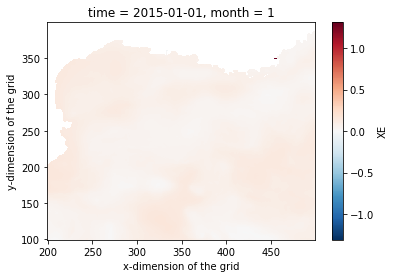

In [25]:
#verify plot of selected area
ano_train.isel(time=0).plot()

#### file test (2021)

In [19]:
ano_test= ano.sel(time='2021')
ano_test=ano_test.isel(ni=slice(200,500),nj=slice(100,400))
ano_test

<xarray.DataArray 'XE' (time: 2920, nj: 300, ni: 300)>
dask.array<getitem, shape=(2920, 300, 300), dtype=float32, chunksize=(1, 300, 300), chunktype=numpy.ndarray>
Coordinates:
    latitude   (nj, ni) float64 dask.array<chunksize=(300, 300), meta=np.ndarray>
    longitude  (nj, ni) float64 dask.array<chunksize=(300, 300), meta=np.ndarray>
  * ni         (ni) float32 200.0 201.0 202.0 203.0 ... 496.0 497.0 498.0 499.0
  * nj         (nj) float32 100.0 101.0 102.0 103.0 ... 396.0 397.0 398.0 399.0
  * time       (time) datetime64[ns] 2021-01-01 ... 2021-12-31T21:00:00
    month      (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12

In [20]:
annee='2021'
path="fichiers_inputs/"+varname+"_anomalie_"+annee+"_"+region+".nc"
ano_test.to_netcdf(path=path)

### Organizing files used on py-eddy-tracker

In [38]:
#parameters
annee='2015_2020'
region = 'f2_1200_sn'  #menor -mediteranne

In [39]:
ds = xr.open_dataset("fichiers_inputs/"+varname+"_anomalie_"+annee+"_"+region+".nc",chunks={'time':100} ).rename_vars({'XE':"SLA"})

# convertir l'unite
ds.SLA.attrs["units"]="m"
ds.SLA.units

# convertir les coordennées
ds['ni']=ds.longitude[0,:].values
ds['nj']=ds.latitude[:,0].values
ds    

<xarray.Dataset>
Dimensions:    (nj: 300, ni: 300, time: 17487)
Coordinates:
    latitude   (nj, ni) float64 dask.array<chunksize=(300, 300), meta=np.ndarray>
    longitude  (nj, ni) float64 dask.array<chunksize=(300, 300), meta=np.ndarray>
  * ni         (ni) float64 2.909 2.924 2.938 2.953 ... 7.215 7.229 7.244 7.258
  * nj         (nj) float64 40.58 40.59 40.6 40.61 ... 43.79 43.8 43.81 43.82
  * time       (time) datetime64[ns] 2015-01-01 ... 2020-12-31T21:00:00
    month      (time) int64 dask.array<chunksize=(100,), meta=np.ndarray>
Data variables:
    SLA        (time, nj, ni) float32 dask.array<chunksize=(100, 300, 300), meta=np.ndarray>

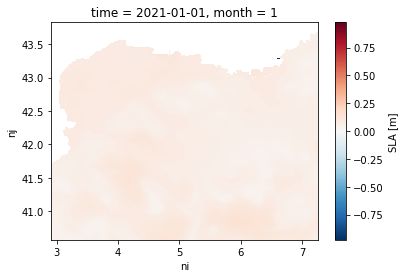

In [19]:
#plot selected area
ds.SLA.isel(time=0).plot()

In [42]:
# créér le fichier separe par jour necessaire dans pyeddytracker

dt=ds.sel(time=ds.time.dt.hour == 0).time.values
for i in dt:
    dtt= np.datetime_as_string(i, unit='D') 
    ds_1 = ds.sel(time=dtt)
    path="fichiers_inputs/SLA_"+dtt+".nc" # 8 files per day
    ds_1.to_netcdf(path=path) 

In [21]:
### creating file with time 00:00

ds_0 = ds.sel(time=ds.time.dt.hour == 0)
path="fichiers_inputs/SLA_"+annee+"_"+region+"_T0.nc"  # 1 file per day
ds_0.to_netcdf(path=path)

In [40]:
client.close()
cluster.close()

In [3]:
ds = xr.open_dataset("fichiers_inputs/SLA_train_segm_2015_2020_f2_1200.nc",chunks={'time':100} )
ds

<xarray.Dataset>
Dimensions:    (nj: 300, ni: 300, time: 2186)
Coordinates:
    latitude   (nj, ni) float64 dask.array<chunksize=(300, 300), meta=np.ndarray>
    longitude  (nj, ni) float64 dask.array<chunksize=(300, 300), meta=np.ndarray>
  * ni         (ni) float64 2.909 2.924 2.938 2.953 ... 7.215 7.229 7.244 7.258
  * nj         (nj) float64 40.58 40.59 40.6 40.61 ... 43.79 43.8 43.81 43.82
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2020-12-31
    month      (time) int64 dask.array<chunksize=(100,), meta=np.ndarray>
Data variables:
    SLA        (time, nj, ni) float32 dask.array<chunksize=(100, 300, 300), meta=np.ndarray>
    mask       (time, nj, ni) int64 dask.array<chunksize=(100, 300, 300), meta=np.ndarray>

In [5]:
ds_test= ds.sel(mask.value=3)

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (3744609915.py, line 1)

In [8]:
type(ds.mask.data)

dask.array.core.Array

In [15]:
ds.mask.data

dask.array<open_dataset-d1c99d7072ca74aee313ae2c28bc5524mask, shape=(2186, 300, 300), dtype=int64, chunksize=(100, 300, 300), chunktype=numpy.ndarray>

In [ ]:
ano_test= ds.sel(time='2017')
ano_test